# Netflix movie search

Finding out what to watch is tough choice mainly because of the abundance of options and the scarcity of time.
Let's follow a data-driven approach to arrive at a decision!

In our [dataset](https://www.kaggle.com/datasets/dgoenrique/netflix-movies-and-tv-shows) of movies, we know the
- description,
- genre
- title
- and the release_year
of the movie.

Putting together a vector index on top of these embedded inputs will create a space where we can search semantically to find our movie choice for tonight.

We are going to browse the movies

- searching with an idea (heartfelt romantic comedy)
- tweak around the results giving more importance to matches in certain input fields
- search in description, genre and title with different search terms for each
- and after finding a close enough movie (that is not quite it), search around utilizing that one, too

## Boilerplate

### Installation

In [1]:
%pip install superlinked==12.23.0

### Imports and constants

In [2]:
import ast
from datetime import timedelta, datetime
import os
import sys

import altair as alt
import pandas as pd
from superlinked import framework as sl

alt.renderers.enable(sl.get_altair_renderer())
alt.data_transformers.disable_max_rows()
pd.set_option("display.max_colwidth", 190)

In [3]:
YEAR_IN_DAYS = 365
TOP_N = 10
DATASET_URL = "https://storage.googleapis.com/superlinked-notebook-netflix-shows-dataset/titles.csv"
# as our latest movie is from 2022 we can set this as the time of the analysis
END_OF_2022_TS = int(datetime(2022, 12, 31, 23, 59).timestamp())
EXECUTOR_DATA = {sl.CONTEXT_COMMON: {sl.CONTEXT_COMMON_NOW: END_OF_2022_TS}}

## Prepare dataset

In [4]:
NROWS = int(os.getenv("NOTEBOOK_TEST_ROW_LIMIT", str(sys.maxsize)))
movie_df = pd.read_csv(DATASET_URL, nrows=NROWS)
# keep only relevant columns
movie_df = (
    movie_df[["description", "genres", "title", "release_year", "id"]]
    .drop_duplicates(subset=["description"])
    .dropna(how="any")
)
# join genres to create a textual column
movie_df["genres"] = movie_df["genres"].apply(lambda x: " ".join(ast.literal_eval(x)))
# convert release year to a timestamp - always the 1st of January
movie_df["timestamp"] = [
    int(pd.Timestamp(year=year, month=1, day=1).timestamp())
    for year in movie_df["release_year"].tolist()
]
movie_df.head()

,description,genres,title,release_year,id,timestamp
0,"This collection includes 12 World War II-era propaganda films — many of which are graphic and offensive — discussed in the docuseries ""Five Came Back.""",documentation,Five Came Back: The Reference Films,1945,ts300399,-788918400
1,A mentally unstable Vietnam War veteran works as a night-time taxi driver in New York City where the perceived decadence and sleaze feed his urge for violent action.,drama crime,Taxi Driver,1976,tm84618,189302400
2,"Intent on seeing the Cahulawassee River before it's turned into one huge lake, outdoor fanatic Lewis Medlock takes his friends on a river-rafting trip they'll never forget into the dange...",drama action thriller european,Deliverance,1972,tm154986,63072000
3,"King Arthur, accompanied by his squire, recruits his Knights of the Round Table, including Sir Bedevere the Wise, Sir Lancelot the Brave, Sir Robin the Not-Quite-So-Brave-As-Sir-Lancelot...",fantasy action comedy,Monty Python and the Holy Grail,1975,tm127384,157766400
4,"12 American military prisoners in World War II are ordered to infiltrate a well-guarded enemy château and kill the Nazi officers vacationing there. The soldiers, most of whom are facing ...",war action,The Dirty Dozen,1967,tm120801,-94694400


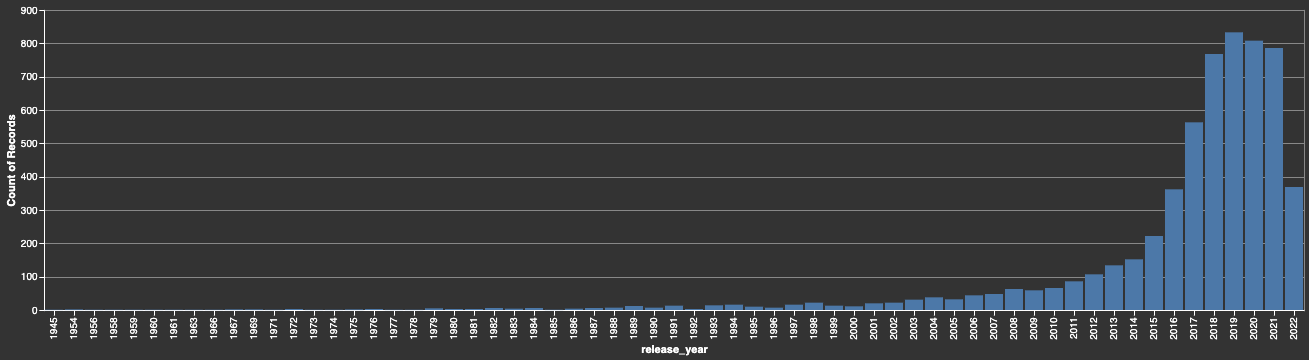

In [5]:
# let's use 4, 10 and 40 years as our period times so that populous areas get more focus
alt.Chart(movie_df[["release_year"]].astype(str)).mark_bar().encode(
    x=alt.X("release_year"), y="count()"
)

## Set up Superlinked

In [6]:
# accommodate our inputs in a typed schema
class MovieSchema(sl.Schema):
    description: sl.String
    title: sl.String
    release_timestamp: sl.Timestamp
    genres: sl.String
    id: sl.IdField

In [7]:
movie = MovieSchema()

In [8]:
# textual fields are embedded using a sentence-transformers model
description_space = sl.TextSimilaritySpace(
    text=movie.description, model="sentence-transformers/paraphrase-MiniLM-L3-v2"
)
title_space = sl.TextSimilaritySpace(
    text=movie.title, model="sentence-transformers/paraphrase-MiniLM-L3-v2"
)
genre_space = sl.TextSimilaritySpace(
    text=movie.genres, model="sentence-transformers/paraphrase-MiniLM-L3-v2"
)
# release date are encoded using our recency space
# periodtimes aim to reflect notable breaks in our scores
recency_space = sl.RecencySpace(
    timestamp=movie.release_timestamp,
    period_time_list=[
        sl.PeriodTime(timedelta(days=4 * YEAR_IN_DAYS)),
        sl.PeriodTime(timedelta(days=10 * YEAR_IN_DAYS)),
        sl.PeriodTime(timedelta(days=40 * YEAR_IN_DAYS)),
    ],
    negative_filter=-0.25,
)

In [9]:
movie_index = sl.Index(
    spaces=[description_space, title_space, genre_space, recency_space]
)

In [10]:
query_text_param = sl.Param("query_text")

simple_query = (
    sl.Query(
        movie_index,
        weights={
            description_space: sl.Param("description_weight"),
            title_space: sl.Param("title_weight"),
            genre_space: sl.Param("genre_weight"),
            recency_space: sl.Param("recency_weight"),
        },
    )
    .find(movie)
    .similar(description_space, query_text_param)
    .similar(title_space, query_text_param)
    .similar(genre_space, query_text_param)
    .limit(sl.Param("limit"))
)

advanced_query = (
    sl.Query(
        movie_index,
        weights={
            description_space: sl.Param("description_weight"),
            title_space: sl.Param("title_weight"),
            genre_space: sl.Param("genre_weight"),
            recency_space: sl.Param("recency_weight"),
        },
    )
    .find(movie)
    .similar(description_space, sl.Param("description_query_text"))
    .similar(title_space, sl.Param("title_query_text"))
    .similar(genre_space, sl.Param("genre_query_text"))
    .limit(sl.Param("limit"))
)

In [11]:
df_parser = sl.DataFrameParser(
    schema=movie, mapping={movie.release_timestamp: "timestamp"}
)

In [12]:
source: sl.InMemorySource = sl.InMemorySource(movie, parser=df_parser)
executor: sl.InMemoryExecutor = sl.InMemoryExecutor(
    sources=[source], indices=[movie_index], context_data=EXECUTOR_DATA
)
app: sl.InMemoryApp = executor.run()

In [13]:
source.put([movie_df])

## Understanding recency

Recency can seem quite complex at first, let's see how the score looks like for the relevant time periods

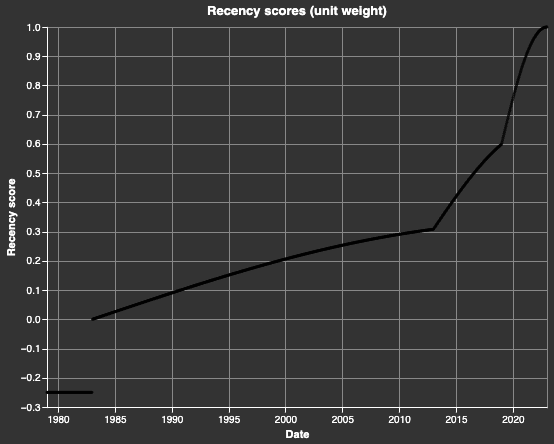

In [14]:
recency_plotter = sl.RecencyPlotter(recency_space, context_data=EXECUTOR_DATA)
chart = recency_plotter.plot_recency_curve()
chart

notice the breaks in the score at 4, 10 and 40 years - those are our period times. Titles older than 40 years get `negative_filter` score.

## Run queries

Let's define a quick util function to present our results in the notebook

In [15]:
def present_result(
    result_to_present: sl.Result,
    cols_to_keep: list[str] | None = None,
) -> pd.DataFrame:
    if cols_to_keep is None:
        cols_to_keep = [
            "description",
            "title",
            "genres",
            "release_year",
            "id",
            "similarity_score",
        ]
    # parse result to dataframe
    df: pd.DataFrame = result_to_present.to_pandas()
    # transform timestamp back to release year
    df["release_year"] = [
        datetime.fromtimestamp(timestamp).year for timestamp in df["release_timestamp"]
    ]
    return df[cols_to_keep]

### Search with user queries

With the simple query, I can search with my text in all of the fields

In [16]:
result: sl.Result = app.query(
    simple_query,
    query_text="Heartfelt romantic comedy",
    description_weight=1,
    title_weight=1,
    genre_weight=1,
    recency_weight=0,
    limit=TOP_N,
)

present_result(result)

,description,title,genres,release_year,id,similarity_score
0,"When a group of people meets at the same party, they form four different relationships, each experiencing similar phases of love.","Love, Surreal and Odd",comedy romance,2017,tm313118,0.543277
1,"'Love Actually' follows the lives of eight very different couples dealing with their love lives, in various loosely and interrelated tales, all set during a frantic month before Christma...",Love Actually,drama comedy romance,2003,tm133767,0.523199
2,"A young woman develops romantic feelings for her best friend, but problems arise when another gal enters the picture.",Must Be... Love,comedy romance,2013,tm188290,0.507749
3,Romantic anthology web series revolving around 12 stories of 12 months of young people on their paths to love.,Love Daily,drama romance,2018,ts90869,0.505947
4,"Love You, is a 2011 Taiwanese drama starring Joseph Chang, Rainie Yang, Kingone Wang, Tiffany Hsu, Alien Huang and Tom Price. It is the second installment of the Fated to Love You trilog...",Drunken to Love You,comedy drama romance,2011,ts44064,0.502316
5,Laida Magtalas is a modern-day Belle who works hard to provide for her family while hoping that someday she will meet her prince charming and that they will live happily ever after toget...,A Very Special Love,comedy drama romance,2008,tm28024,0.502180
6,"It tells the love story of two childhood sweethearts that spans 19 years. Chen Xiao Xi is a cute and small girl with a lot of positive energy. She gets to know Jiang Chen, a tall and pro...",A Love So Beautiful,comedy romance,2017,ts77034,0.497101
7,"Christina's love life is stuck in neutral. After years of avoiding the hazards of a meaningful relationship, one night while club-hopping with her girlfriends, she meets Peter, her perfe...",The Sweetest Thing,comedy romance,2002,tm111600,0.495610
8,"Mike Birbiglia shares a lifetime of romantic blunders and misunderstandings. On this painfully honest but hilarious journey, Birbiglia struggles to find reason in an area where it may be...",Mike Birbiglia: My Girlfriend's Boyfriend,comedy documentation romance,2013,tm171965,0.495530
9,"An LA girl, unlucky in love, falls for an East Coast guy on a dating app and decides to surprise him for the holidays, only to discover that she's been catfished. This lighthearted roman...",Love Hard,romance comedy,2021,tm1093099,0.488398


After looking at the results, I see some titles I have already seen. I can bias towards recent titles by upweighting recency. Weights are normalized to have unit sum, so you don't have to worry about how you set them.

In [17]:
second_result: sl.Result = app.query(
    simple_query,
    query_text="Heartfelt romantic comedy",
    description_weight=1,
    title_weight=1,
    genre_weight=1,
    recency_weight=3,
    limit=TOP_N,
)

present_result(second_result)

,description,title,genres,release_year,id,similarity_score
0,"In this romantic comedy, several friends, each dealing with unhappy love lives, turn to each other for help - but not always with the best results.",F*ck Love Too,comedy romance,2022,tm1203307,0.367203
1,"Fidelity tells a story of marital fidelity, in particular the one of Carlo and Margherita, a young couple who needs to face the deflagrant consequences of an alleged betrayal. Their rela...","Devotion, a Story of Love and Desire",drama romance,2022,ts280892,0.359400
2,This black humor pan-Arabic anthology series is about love in general – and relationships in particular.,"Love, Life & Everything in Between",comedy drama romance,2022,ts329711,0.358947
3,"A relatable romance drama about a couple in their 30s preparing for marriage. While they were expecting a happy ending like something out of a fairy tale, the reality of their preparatio...",Welcome to Wedding Hell,drama romance,2022,ts344043,0.354152
4,"An ad executive and a fashion designer-blogger don't believe in love, so they place a bet to make the other fall head over heels - with unusual tactics.",Love Tactics,comedy romance,2022,tm1152224,0.352390
5,"Often (mis)guided by a cheeky imaginary wizard, an awkward and lonely 20-something struggles to get out of his own way in his quest for a girlfriend.",Eternally Confused and Eager for Love,comedy romance,2022,ts330012,0.351561
6,"An LA girl, unlucky in love, falls for an East Coast guy on a dating app and decides to surprise him for the holidays, only to discover that she's been catfished. This lighthearted roman...",Love Hard,romance comedy,2021,tm1093099,0.348037
7,"Guille decides it's time to take the next step and that's how she looks to marry her sweetheart, but things get complicated and nothing goes as planned.","Let's Tie the Knot, Honey!",comedy romance,2022,tm1204412,0.347946
8,Aspiring pop star Erica ends up as the entertainment at her ex-fiancé’s wedding after reluctantly taking a gig at a luxurious island resort while in the wake of a music career meltdown.,Resort to Love,romance comedy,2021,tm1037704,0.346568
9,"A modern love story set in the near future where an AI building is powered by human feelings. Due to a software glitch, it falls in love with a real girl, escapes the building into the b...",AI Love You,scifi comedy romance drama,2022,tm1160424,0.345295


Still using the simple query, I can give more weight to spaces if I think my query is more related to that space - matches there should count more. Here I give additional weight to the genre, leave the description as is, and downweight the title as my query text is mostly a genre with some additional context. I keep recency with unit weight too, as I would like my results to be a bit biased towards recent movies.

In [18]:
result = app.query(
    simple_query,
    query_text="Heartfelt romantic comedy",
    description_weight=1,
    title_weight=0.1,
    genre_weight=2,
    recency_weight=1,
    limit=TOP_N,
)

present_result(result)

,description,title,genres,release_year,id,similarity_score
0,"In this romantic comedy, several friends, each dealing with unhappy love lives, turn to each other for help - but not always with the best results.",F*ck Love Too,comedy romance,2022,tm1203307,0.523558
1,"An LA girl, unlucky in love, falls for an East Coast guy on a dating app and decides to surprise him for the holidays, only to discover that she's been catfished. This lighthearted roman...",Love Hard,romance comedy,2021,tm1093099,0.497132
2,"A relatable romance drama about a couple in their 30s preparing for marriage. While they were expecting a happy ending like something out of a fairy tale, the reality of their preparatio...",Welcome to Wedding Hell,drama romance,2022,ts344043,0.487172
3,This black humor pan-Arabic anthology series is about love in general – and relationships in particular.,"Love, Life & Everything in Between",comedy drama romance,2022,ts329711,0.484842
4,Short films follow young adults as they navigate the gamut of emotions that come with finding romantic connection in unexpected places.,Feels Like Ishq,drama romance comedy,2021,ts283610,0.483909
5,Incurable romantic Lotte's life is upended when her plans for a picture-perfect wedding unravel--just as her self-absorbed sister gets engaged.,Just Say Yes,comedy romance,2021,tm904862,0.481923
6,"In pursuit of both success and validation, a group of tech-savvy individuals juggle intimate encounters, first impressions and romantic opportunities.",Slay,romance comedy,2021,tm1038025,0.481751
7,"In this rom-com challenging the concept of soulmates, parallel storylines portray four single friends as they pair up in different couple combinations.",Four to Dinner,comedy romance,2022,tm1137862,0.477245
8,Aspiring pop star Erica ends up as the entertainment at her ex-fiancé’s wedding after reluctantly taking a gig at a luxurious island resort while in the wake of a music career meltdown.,Resort to Love,romance comedy,2021,tm1037704,0.476527
9,"Guille decides it's time to take the next step and that's how she looks to marry her sweetheart, but things get complicated and nothing goes as planned.","Let's Tie the Knot, Honey!",comedy romance,2022,tm1204412,0.474851


With the advanced query, I can even supply different search terms for each attribute of the movie.

In [19]:
result = app.query(
    advanced_query,
    description_query_text="Heartfelt lovely romantic comedy for a cold autumn evening.",
    title_query_text="love",
    genre_query_text="drama comedy romantic",
    description_weight=1,
    title_weight=1,
    genre_weight=1,
    recency_weight=0,
    limit=TOP_N,
)

present_result(result)

,description,title,genres,release_year,id,similarity_score
0,"'Love Actually' follows the lives of eight very different couples dealing with their love lives, in various loosely and interrelated tales, all set during a frantic month before Christma...",Love Actually,drama comedy romance,2003,tm133767,0.685763
1,Rebellious Mickey and good-natured Gus navigate the thrills and agonies of modern relationships.,Love,comedy drama romance,2016,ts38511,0.653285
2,"An LA girl, unlucky in love, falls for an East Coast guy on a dating app and decides to surprise him for the holidays, only to discover that she's been catfished. This lighthearted roman...",Love Hard,romance comedy,2021,tm1093099,0.607638
3,Romantic anthology web series revolving around 12 stories of 12 months of young people on their paths to love.,Love Daily,drama romance,2018,ts90869,0.606869
4,"Adam and Marklin’s 5-year relationship has gone from a passionate flame to a simmer, forcing them to reconcile with each other’s shortcomings while their friends endlessly search for lov...",Almost Love,comedy drama romance,2019,tm472195,0.603985
5,Laida Magtalas is a modern-day Belle who works hard to provide for her family while hoping that someday she will meet her prince charming and that they will live happily ever after toget...,A Very Special Love,comedy drama romance,2008,tm28024,0.598140
6,A rising black painter tries to break into a competitive art world while balancing an unexpected romance with an ambitious law student.,Really Love,romance drama,2020,tm946360,0.592896
7,"Two young kids fall in love with each other. But the passion is too consuming for the parents of Jade. The parents try to stop them from seeing each other. But when this doesn't work, Da...",Endless Love,romance drama,1981,tm130586,0.590470
8,"A young woman develops romantic feelings for her best friend, but problems arise when another gal enters the picture.",Must Be... Love,comedy romance,2013,tm188290,0.577796
9,"Near by Christmas, in an old and charming town in Transylvania, Sebastian and Aprilia start a beautiful love story. However, nothing is as simple as it would seem. Being influenced by th...",Love Is a Story,romance european comedy,2015,tm368725,0.577175


And even give different weights to each subsearch if I really do care that the title is related to love but I am not really emotionally attached to my description of the movie I would want to see.

In [20]:
result = app.query(
    advanced_query,
    description_query_text="Heartfelt lovely romantic comedy for a cold autumn evening.",
    title_query_text="love",
    genre_query_text="drama comedy romantic",
    description_weight=0.2,
    title_weight=3,
    genre_weight=1,
    recency_weight=0,
    limit=TOP_N,
)

present_result(result)

,description,title,genres,release_year,id,similarity_score
0,Rebellious Mickey and good-natured Gus navigate the thrills and agonies of modern relationships.,Love,comedy drama romance,2016,ts38511,0.655329
1,"'Love Actually' follows the lives of eight very different couples dealing with their love lives, in various loosely and interrelated tales, all set during a frantic month before Christma...",Love Actually,drama comedy romance,2003,tm133767,0.612040
2,The story of a family and the various situations navigated by a husband and wife.,Love,thriller drama,2020,tm946277,0.585873
3,"Adam and Marklin’s 5-year relationship has gone from a passionate flame to a simmer, forcing them to reconcile with each other’s shortcomings while their friends endlessly search for lov...",Almost Love,comedy drama romance,2019,tm472195,0.558795
4,A rising black painter tries to break into a competitive art world while balancing an unexpected romance with an ambitious law student.,Really Love,romance drama,2020,tm946360,0.554694
5,"Two young kids fall in love with each other. But the passion is too consuming for the parents of Jade. The parents try to stop them from seeing each other. But when this doesn't work, Da...",Endless Love,romance drama,1981,tm130586,0.552415
6,"The story of Richard and Mildred Loving, an interracial couple, whose challenge of their anti-miscegenation arrest for their marriage in Virginia led to a legal battle that would end at ...",Loving,drama romance,2016,tm219233,0.551597
7,Laida Magtalas is a modern-day Belle who works hard to provide for her family while hoping that someday she will meet her prince charming and that they will live happily ever after toget...,A Very Special Love,comedy drama romance,2008,tm28024,0.541631
8,"Love, Now is a 72 episode Taiwanese idol romance drama television series created and developed by SETTV. It stars Annie Chen, George Hu as the main leads and Bobby Dou, Harry Chang from ...","Love, Now",drama,2012,ts69208,0.535823
9,"Ian Montes is a picture of success. Despite being a son of a shipping tycoon, Ian refused to just ride in his father's empire. He built his own real estate company and earned his first m...",A Love Story,drama romance,2007,tm76399,0.529553


Then I can bias again towards recent movies

In [21]:
result = app.query(
    advanced_query,
    description_query_text="Heartfelt lovely romantic comedy for a cold autumn evening.",
    title_query_text="love",
    genre_query_text="drama comedy romantic",
    description_weight=0.2,
    title_weight=3,
    genre_weight=1,
    recency_weight=5,
    limit=TOP_N,
)

present_result(result)

,description,title,genres,release_year,id,similarity_score
0,"After his ad agency goes bankrupt, an indebted Fırat falls for a singer at a yoga retreat and joins her on a journey of self-realization.",Doom of Love,romance drama,2022,tm1218702,0.373493
1,"An ad executive and a fashion designer-blogger don't believe in love, so they place a bet to make the other fall head over heels - with unusual tactics.",Love Tactics,comedy romance,2022,tm1152224,0.372208
2,"An LA girl, unlucky in love, falls for an East Coast guy on a dating app and decides to surprise him for the holidays, only to discover that she's been catfished. This lighthearted roman...",Love Hard,romance comedy,2021,tm1093099,0.370368
3,"Fidelity tells a story of marital fidelity, in particular the one of Carlo and Margherita, a young couple who needs to face the deflagrant consequences of an alleged betrayal. Their rela...","Devotion, a Story of Love and Desire",drama romance,2022,ts280892,0.366119
4,This black humor pan-Arabic anthology series is about love in general – and relationships in particular.,"Love, Life & Everything in Between",comedy drama romance,2022,ts329711,0.363568
5,"A modern love story set in the near future where an AI building is powered by human feelings. Due to a software glitch, it falls in love with a real girl, escapes the building into the b...",AI Love You,scifi comedy romance drama,2022,tm1160424,0.360696
6,"Often (mis)guided by a cheeky imaginary wizard, an awkward and lonely 20-something struggles to get out of his own way in his quest for a girlfriend.",Eternally Confused and Eager for Love,comedy romance,2022,ts330012,0.360192
7,The story of a family and the various situations navigated by a husband and wife.,Love,thriller drama,2020,tm946277,0.356950
8,"Fashion assistant Maca has just about got her life together after a devastating breakup, when Leo, the man who broke her heart returns. Seeking support from best friends, Adriana and Jim...",Sounds Like Love,comedy music romance drama,2021,tm876608,0.352082
9,"Haruto Asakura falls in love with hairdresser Misaki Ariake and asks her out. Watching Misaki Ariake work hard to achieve what she wants, Haruto Asakura, who almost gave up his dream to ...",Love Like the Falling Petals,drama romance,2022,tm1119015,0.348676


Or maybe to older ones

In [22]:
result = app.query(
    advanced_query,
    description_query_text="Heartfelt lovely romantic comedy for a cold autumn evening.",
    title_query_text="love",
    genre_query_text="drama comedy romantic",
    description_weight=0.2,
    title_weight=3,
    genre_weight=1,
    recency_weight=-10,
    limit=TOP_N,
)

present_result(result)

,description,title,genres,release_year,id,similarity_score
0,"Two young kids fall in love with each other. But the passion is too consuming for the parents of Jade. The parents try to stop them from seeing each other. But when this doesn't work, Da...",Endless Love,romance drama,1981,tm130586,0.300280
1,"Anil, a street singer, is humiliated and driven out of Bombay along with his mother. However, he soon becomes a famous performer but the enemies from his past try to destroy his hard-ear...",Disco Dancer,drama romance,1982,tm52815,0.258539
2,"An honest man dreams of a better life for his family, but a childhood friend leads him into a world of crime that keeps happiness just out of reach.",Ujala,romance crime drama,1959,tm358653,0.257860
3,Two talented song-and-dance men team up after the war to become one of the hottest acts in show business. In time they befriend and become romantically involved with the beautiful Haynes...,White Christmas,romance comedy,1954,tm16479,0.254693
4,"Brian Cohen is an average young Jewish man, but through a series of ridiculous events, he gains a reputation as the Messiah. When he's not dodging his followers or being scolded by his s...",Life of Brian,comedy,1979,tm70993,0.252692
5,"Geeky student Arnie Cunningham falls for Christine, a rusty 1958 Plymouth Fury, and becomes obsessed with restoring the classic automobile to her former glory. As the car changes, so doe...",Christine,horror thriller european,1983,tm54450,0.252198
6,"Maharaj Brajbhan lives a wealthy lifestyle in Bharatpur, India along with his wife, Badi Rani, but have been unable to conceive for Bharatpur, and have no choice but to leave it's reigns...",Bandie,drama action romance,1978,tm16812,0.251707
7,"Two small children and a ship's cook survive a shipwreck and find safety on an idyllic tropical island. Soon, however, the cook dies and the young boy and girl are left on their own. Day...",The Blue Lagoon,romance action drama,1980,tm98978,0.247627
8,"In the 1930s, bored waitress Bonnie Parker falls in love with an ex-con named Clyde Barrow and together they start a violent crime spree through the country, stealing cars and robbing ba...",Bonnie and Clyde,crime drama action,1967,tm119281,0.247115
9,"Ragab, a poor sailor, returns home to Alexandria after three years of absence, during which he tried to save money to marry his one true love, Hamedah. But there's trouble on the harbor,...",Dark Waters,action drama romance thriller,1956,tm204541,0.246552


notice that every movie before 1984 has the same recency score as our largest period time is 40 years.

### Search with a movie and queries

Now I found a movie in the last result set that I have already seen but I would love something similar. White Christmas (1954) is a story about people forming a rock-band and of course there is some love along the way. It has the id "tm16479".

I can query my dataset using this movie, too! Let's adjust the defined query first:

In [23]:
with_movie_query = advanced_query.with_vector(movie, sl.Param("movie_id"))

with this modification, I can add a movie from the dataset to the search.

Let's first just focus on movies with similar descriptions. The first result will of course be the movie we are searching with.

In [24]:
result = app.query(
    with_movie_query,
    description_query_text="",
    title_query_text="",
    genre_query_text="",
    description_weight=1,
    title_weight=0,
    genre_weight=0,
    recency_weight=0,
    movie_id="tm16479",
    limit=TOP_N,
)

present_result(result)

,description,title,genres,release_year,id,similarity_score
0,Two talented song-and-dance men team up after the war to become one of the hottest acts in show business. In time they befriend and become romantically involved with the beautiful Haynes...,White Christmas,romance comedy,1954,tm16479,0.320335
1,"On a bet, a gridiron hero at John Hughes High School sets out to turn a bespectacled plain Jane into a beautiful and popular prom queen in this outrageous send-up of the teen movies of t...",Not Another Teen Movie,comedy,2001,tm58382,0.197771
2,"A visionary, innovator, and originator who defied categorization and embodied the word cool—a foray into the life and career of musical and cultural icon Miles Davis.",Miles Davis: Birth of the Cool,documentation music,2019,tm446625,0.195352
3,A loud poem. A whimsical western tale of music and love.,Paradox,western fantasy music,2018,tm370440,0.193642
4,"A dream of the hope for intimacy and love in a brutal, divisive world.",Condom Lead,drama,2013,tm1036195,0.189571
5,"Comedies Honest, introspective comic Simon Amstell digs deep and delivers a uniquely vulnerable stand-up set on love, ego, intimacy and ayahuasca.",Simon Amstell: Set Free,comedy,2019,tm825952,0.187296
6,"Trip, a young roadie for Metallica, is sent on an urgent mission during the band's show. But what seems like a simple assignment turns into a surreal adventure.",Metallica: Through the Never,music,2013,tm171228,0.186985
7,"Sing along and dance with Bailey, Franny, Kip, Lulu and Tilly in this collection of music videos that will get you in the mood to move and groove!",Word Party Songs,animation family,2020,ts251607,0.185923
8,"Shoaib's life takes a precarious turn when he finds himself pitted against a younger contemporary - not just in ""business"", but in love...",Once Upon a Time in Mumbai Dobaara!,action crime drama romance,2013,tm181550,0.185790
9,"Ronny Chieng (""The Daily Show,"" ""Crazy Rich Asians"") takes center stage in this stand-up special and riffs on modern American life and more.",Ronny Chieng: Asian Comedian Destroys America!,comedy,2019,tm844662,0.183472


I got back movies that focus more on the rock-band aspect of the movie. With query parameters I can try to skew the results to be more related to family.

In [25]:
result = app.query(
    with_movie_query,
    description_query_text="family",
    title_query_text="",
    genre_query_text="",
    description_weight=1,
    title_weight=0,
    genre_weight=0,
    recency_weight=0,
    description_query_weight=1,
    movie_id="tm16479",
    limit=TOP_N,
)

present_result(result)

,description,title,genres,release_year,id,similarity_score
0,Two talented song-and-dance men team up after the war to become one of the hottest acts in show business. In time they befriend and become romantically involved with the beautiful Haynes...,White Christmas,romance comedy,1954,tm16479,0.348183
1,"A new couple, their exes and their children navigate the emotional challenges and tricky logistics of blended family life in this Swedish dramedy.",Bonus Family,drama comedy reality family documentation music european,2017,ts55939,0.301302
2,An estranged family gathers together in New York for an event celebrating the artistic work of their father.,The Meyerowitz Stories (New and Selected),comedy drama,2017,tm244206,0.300274
3,"Reunited in their hometown for their father's funeral, two self-interested brothers meet a peculiar woman who shares a huge secret about their family.",The Bros,comedy fantasy,2017,tm357708,0.297017
4,"Years after his father disowns his adopted brother for marrying a woman of lower social standing, a young man goes on a mission to reunite his family.",Kabhi Khushi Kabhie Gham,drama romance,2001,tm36475,0.294985
5,Three grown siblings must rethink their idea of family when they learn their parents are getting divorced and have their eyes on new partners.,Love Storm,family,2016,ts83449,0.291048
6,A dramatic story about a girl and her giving father.,Sen Benim HerŞeyimsin,comedy,2016,tm311456,0.286462
7,Estranged family members re-unite to determine whether to pull the family patriarch out of life support or not.,Dedemin Fişi,comedy family,2016,tm233121,0.282727
8,The story of a family and the various situations navigated by a husband and wife.,Love,thriller drama,2020,tm946277,0.279838
9,Three prosperous women -- including a mother and her daughter -- fall for a seductive man in Colombia's Coffee Triangle.,Playing with Fire,drama,2019,ts87680,0.272556


Taking a closer look at the description of these result movies, we can see that they share some aspect of the movie we are searching with - blended together with some notion of family:

After all, this evening I am in the mood for something light - I can also skew the results towards a specific genre: comedy

In [26]:
result = app.query(
    with_movie_query,
    description_query_text="",
    title_query_text="",
    genre_query_text="comedy",
    description_weight=1,
    title_weight=0,
    genre_weight=2,
    recency_weight=0,
    description_query_weight=1,
    movie_id="tm16479",
    limit=TOP_N,
)

present_result(result)

,description,title,genres,release_year,id,similarity_score
0,Two talented song-and-dance men team up after the war to become one of the hottest acts in show business. In time they befriend and become romantically involved with the beautiful Haynes...,White Christmas,romance comedy,1954,tm16479,0.599050
1,"On a bet, a gridiron hero at John Hughes High School sets out to turn a bespectacled plain Jane into a beautiful and popular prom queen in this outrageous send-up of the teen movies of t...",Not Another Teen Movie,comedy,2001,tm58382,0.566562
2,Get ready to scream with laughter! Sam Kinison's primal scream will echo down through the comedy hall of fame summing up so much of modernity's horror and stupidity. This concert was tap...,Sam Kinison: Family Entertainment Hour,comedy,1991,tm8687,0.558721
3,"Brian Cohen is an average young Jewish man, but through a series of ridiculous events, he gains a reputation as the Messiah. When he's not dodging his followers or being scolded by his s...",Life of Brian,comedy,1979,tm70993,0.552322
4,"Nerdy accountant Harold and his irrepressible friend, Kumar, get stoned watching television and find themselves utterly bewitched by a commercial for White Castle. Convinced there must b...",Harold & Kumar Go to White Castle,comedy,2004,tm89036,0.550538
5,"A sitcom about a British-Nigerian family living in Peckham, covering themes such as financial worries, Bayo Adebanjo's insistence on instilling African style discipline on his children, ...",Meet the Adebanjos,comedy,2012,ts167724,0.548235
6,Comedic pianist Tim Minchin performs a host of his catchy songs that touch on everything from the Middle East to the healing power of canvas bags.,Tim Minchin: So F**king Rock Live,comedy,2008,tm41953,0.548067
7,"""Say goodnight to the bad guys"" picks up where ""A Sh*t river runs through it"" left off. it's a year after the events of A.S.R.R.T.I and Ricky, Julian, and bubbles are rich with cash, but...",Trailer Park Boys: Say Goodnight to the Bad Guys,comedy,2008,tm56428,0.547606
8,"What About Dick? begins with the birth of a sex toy invented in Shagistan in 1898 by Deepak Rushdie Obi Ben Kingsley (Eddie Izzard), and tells the story of the subsequent decline of the ...",What About Dick?,comedy,2012,tm72251,0.543357
9,"A sitcom about the Ojo family, a newly-rich family that moves into a classy Lagos neighborhood. Each episode revolves around the hilarious antics of Mrs. Ojo and her obsession with keepi...",Ojo's in d' House,comedy,2013,ts261583,0.541752
